## Notebook showcasing the various options in Roodmus for analysis and visualisations
In this notebook, the user can load metadata from one or several jobs from a processing pipeline done in RELION or cryoSPARC. This metadata, along with the ground-truth particle parameters are loaded into data frames, which allow for easy and conveniet plotting. We also provide several convenient functions to make plots.


In [1]:
### imports
# general
import numpy as np
import pandas as pd

# roodmus
from importlib import reload
import roodmus.analysis.utils
reload(roodmus.analysis.utils)
from roodmus.analysis.utils import load_data
from roodmus.analysis.plot_ctf import plot_CTF, plot_defocus_scatter
from roodmus.analysis.plot_picking import (
    label_micrograph_picked, 
    label_micrograph_truth,
    label_micrograph_truth_and_picked, 
    plot_precision, plot_recall, 
    plot_boundary_investigation,
    plot_overlap_investigation, 
    plot_precision_and_recall, 
    plot_f1_score
)
from roodmus.analysis.plot_frames import plot_frame_distribution
from roodmus.analysis.plot_classes import plot_2Dclass_precision, plot_2Dclasses_frames
from roodmus.analysis.plot_alignment import plot_picked_pose_distribution, plot_true_pose_distribution


In [3]:
### data loading
### steered MD data set for the Covid-19 spike protein (PDB id: 6xm5)
config_dir = "/home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/mrc/"
meta_files = [
    "data/6xm5_steered_Roodmus_2/cryoSPARC/J508_picked_particles.cs",
    # "data/6xm5_steered_Roodmus_2/cryoSPARC/J511_050_particles.cs",
    # "data/6xm5_steered_Roodmus_2/cryoSPARC/J513_passthrough_particles_selected.cs",
    # "data/6xm5_steered_Roodmus_2/cryoSPARC/J515_topaz_picked_particles.cs",
    # "data/6xm5_steered_Roodmus_2/cryoSPARC/J518_050_particles.cs",
    # ["data/6xm5_steered_Roodmus_2/cryoSPARC/J519_class_00_final_particles.cs",
    #      "data/6xm5_steered_Roodmus_2/cryoSPARC/J519_passthrough_particles_class_0.cs"],
    # ["data/6xm5_steered_Roodmus_2/cryoSPARC/J519_class_01_final_particles.cs",
    #     "data/6xm5_steered_Roodmus_2/cryoSPARC/J519_passthrough_particles_class_1.cs"],
    # ["data/6xm5_steered_Roodmus_2/cryoSPARC/J519_class_02_final_particles.cs",
    #     "data/6xm5_steered_Roodmus_2/cryoSPARC/J519_passthrough_particles_class_2.cs"],
    # ["data/6xm5_steered_Roodmus_2/cryoSPARC/J519_class_03_final_particles.cs",
    #     "data/6xm5_steered_Roodmus_2/cryoSPARC/J519_passthrough_particles_class_3.cs"],
    # ["data/6xm5_steered_Roodmus_2/cryoSPARC/J520_003_particles.cs",
    #     "data/6xm5_steered_Roodmus_2/cryoSPARC/J520_passthrough_particles.cs"],
    # ["data/6xm5_steered_Roodmus_2/cryoSPARC/J521_004_particles.cs",
    #     "data/6xm5_steered_Roodmus_2/cryoSPARC/J521_passthrough_particles.cs"],
    # ["data/6xm5_steered_Roodmus_2/cryoSPARC/J523_005_particles.cs",
    #     "data/6xm5_steered_Roodmus_2/cryoSPARC/J523_passthrough_particles.cs"],
    # "data/6xm5_steered_Roodmus_2/cryoSPARC/J529_050_particles.cs",
    # "data/6xm5_steered_Roodmus_2/cryoSPARC/J526_passthrough_particles.cs",
]

jobtypes = {
    "data/6xm5_steered_Roodmus_2/cryoSPARC/J508_picked_particles.cs": "blob picker",
    "data/6xm5_steered_Roodmus_2/cryoSPARC/J511_050_particles.cs": "2D classification",
    "data/6xm5_steered_Roodmus_2/cryoSPARC/J513_passthrough_particles_selected.cs": "2D class selection",
    "data/6xm5_steered_Roodmus_2/cryoSPARC/J515_topaz_picked_particles.cs": "topaz picking",
    "data/6xm5_steered_Roodmus_2/cryoSPARC/J518_050_particles.cs": "2D classification 2",
    "data/6xm5_steered_Roodmus_2/cryoSPARC/J519_class_00_final_particles.cs": "3D class 0",
    "data/6xm5_steered_Roodmus_2/cryoSPARC/J519_class_01_final_particles.cs": "3D class 1",
    "data/6xm5_steered_Roodmus_2/cryoSPARC/J519_class_02_final_particles.cs": "3D class 2",
    "data/6xm5_steered_Roodmus_2/cryoSPARC/J519_class_03_final_particles.cs": "3D class 3",
    "data/6xm5_steered_Roodmus_2/cryoSPARC/J520_003_particles.cs": "Refined class 0",
    "data/6xm5_steered_Roodmus_2/cryoSPARC/J521_004_particles.cs": "Refined class 1",
    "data/6xm5_steered_Roodmus_2/cryoSPARC/J523_005_particles.cs": "Homogeneous refinement",
    "data/6xm5_steered_Roodmus_2/cryoSPARC/J529_050_particles.cs": "2D classification class 0",
    "data/6xm5_steered_Roodmus_2/cryoSPARC/J526_passthrough_particles.cs": "Flexible refinement",
}

particle_diameter = 100 # approximate particle diameter in Angstroms
ugraph_shape = (4000, 4000) # shape of the micrograph in pixels. Only needs to be given if the metadata file is a .star file
verbose = True
ignore_missing_files = True
enable_tqdm = True

for i, meta_file in enumerate(meta_files):
    if i == 0:
        analysis = load_data(meta_file, config_dir, particle_diameter, ugraph_shape=ugraph_shape, verbose=verbose, enable_tqdm=enable_tqdm, ignore_missing_files=ignore_missing_files) # creates the class
    else:
        analysis.add_data(meta_file, config_dir, verbose=verbose) # updates the class with the next metadata file


debug
loading metadata from data/6xm5_steered_Roodmus_2/cryoSPARC/J508_picked_particles.cs...
loaded metadata from data/6xm5_steered_Roodmus_2/cryoSPARC/J508_picked_particles.cs. determined file type: cs


Dictionaries now contain 1968039 particles and 0 true particles
added 1968039 particles from data/6xm5_steered_Roodmus_2/cryoSPARC/J508_picked_particles.cs


loading micrographs: 100%|██████████| 800/800 [05:52<00:00,  2.27it/s, micrograph=000799.mrc]

Loaded ground-truth particle positions from config files
Dictionaries now contain 1968039 particles and 200000 true particles
Added 200000 particles from /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/mrc/


In [ ]:
### data loading
### steered MD data set for the c3-c3b complex (from morphing trajectory)
config_dir = "/home/mjoosten1/projects/roodmus/data/c3c3b/mrc"
meta_files = [
    # "data/c3c3b/cryoSPARC/topaz_picked_particles.cs",
    # "data/c3c3b/cryoSPARC/J543_050_particles.cs",
    # ["data/c3c3b/cryoSPARC/J545_class_00_final_particles.cs",
    #     "data/c3c3b/cryoSPARC/J545_passthrough_particles_class_0.cs"],
    # ["data/c3c3b/cryoSPARC/J545_class_01_final_particles.cs",
    #     "data/c3c3b/cryoSPARC/J545_passthrough_particles_class_1.cs"],
    # ["data/c3c3b/cryoSPARC/J545_class_02_final_particles.cs",
    #     "data/c3c3b/cryoSPARC/J545_passthrough_particles_class_2.cs"],
    # ["data/c3c3b/cryoSPARC/J545_class_03_final_particles.cs",
    #     "data/c3c3b/cryoSPARC/J545_passthrough_particles_class_3.cs"],
    # ["data/c3c3b/cryoSPARC/J547_class_00_00042_particles.cs",
    #     "data/c3c3b/cryoSPARC/J547_passthrough_particles_class_0.cs"],
    # ["data/c3c3b/cryoSPARC/J547_class_01_00042_particles.cs",
    #     "data/c3c3b/cryoSPARC/J547_passthrough_particles_class_1.cs"],
    # ["data/c3c3b/cryoSPARC/J547_class_02_00042_particles.cs",
    #     "data/c3c3b/cryoSPARC/J547_passthrough_particles_class_2.cs"],
    # ["data/c3c3b/cryoSPARC/J550_class_00_00062_particles.cs",
    #     "data/c3c3b/cryoSPARC/J550_passthrough_particles_class_0.cs"],
    # ["data/c3c3b/cryoSPARC/J550_class_01_00062_particles.cs",
    #     "data/c3c3b/cryoSPARC/J550_passthrough_particles_class_1.cs"],
    # ["data/c3c3b/cryoSPARC/J550_class_02_00062_particles.cs",
    #     "data/c3c3b/cryoSPARC/J550_passthrough_particles_class_2.cs"],
    # ["data/c3c3b/cryoSPARC/J551_002_particles.cs",
    #     "data/c3c3b/cryoSPARC/J551_passthrough_particles.cs"],
    # ["data/c3c3b/cryoSPARC/J552_002_particles.cs",
    #     "data/c3c3b/cryoSPARC/J552_passthrough_particles.cs"],
    # ["data/c3c3b/cryoSPARC/J553_002_particles.cs",
    #     "data/c3c3b/cryoSPARC/J553_passthrough_particles.cs"],
    # ["data/c3c3b/cryoSPARC/J562_003_particles.cs",
    #     "data/c3c3b/cryoSPARC/J562_passthrough_particles.cs"],
    # "data/c3c3b/cryoSPARC/J567_passthrough_particles.cs",
    "data/c3c3b/cryoSPARC/J574_passthrough_particles.cs",
]

jobtypes = {
    "data/c3c3b/cryoSPARC/topaz_picked_particles.cs": "topaz picking",
    "data/c3c3b/cryoSPARC/J543_050_particles.cs": "2D classification",
    "data/c3c3b/cryoSPARC/J545_class_00_final_particles.cs": "3D class 0",
    "data/c3c3b/cryoSPARC/J545_class_01_final_particles.cs": "3D class 1",
    "data/c3c3b/cryoSPARC/J545_class_02_final_particles.cs": "3D class 2",
    "data/c3c3b/cryoSPARC/J545_class_03_final_particles.cs": "3D class 3",
    "data/c3c3b/cryoSPARC/J547_class_00_00042_particles.cs": "Refined class 0",
    "data/c3c3b/cryoSPARC/J547_class_01_00042_particles.cs": "Refined class 1",
    "data/c3c3b/cryoSPARC/J547_class_02_00042_particles.cs": "Refined class 2",
    "data/c3c3b/cryoSPARC/J550_class_00_00062_particles.cs": "class 0 refi 1",
    "data/c3c3b/cryoSPARC/J550_class_01_00062_particles.cs": "class 1 refi 1",
    "data/c3c3b/cryoSPARC/J550_class_02_00062_particles.cs": "class 2 refi 1",
    "data/c3c3b/cryoSPARC/J551_002_particles.cs": "class 0 refi 2",
    "data/c3c3b/cryoSPARC/J552_002_particles.cs": "class 1 refi 2",
    "data/c3c3b/cryoSPARC/J553_002_particles.cs": "class 2 refi 2",
    "data/c3c3b/cryoSPARC/J562_003_particles.cs": "all classes refi",
    "data/c3c3b/cryoSPARC/J567_passthrough_particles.cs": "flexible refinement",
    "data/c3c3b/cryoSPARC/J574_passthrough_particles.cs": "flexible refinement 2",
}

particle_diameter = 100 # approximate particle diameter in Angstroms
ugraph_shape = (4000, 4000) # shape of the micrograph in pixels. Only needs to be given if the metadata file is a .star file
verbose = True
ignore_missing_files = True
enable_tqdm = True

for i, meta_file in enumerate(meta_files):
    if i == 0:
        analysis = load_data(meta_file, config_dir, particle_diameter, ugraph_shape=ugraph_shape, verbose=verbose, enable_tqdm=enable_tqdm, ignore_missing_files=ignore_missing_files) # creates the class
    else:
        analysis.add_data(meta_file, config_dir, verbose=verbose) # updates the class with the next metadata file


In [ ]:
### data loading
### D.E.Shaw MD data set for the transcription-replication complex from Covid-19
config_dir = "data/DESRES/MapReconstruction/Micrographs"
meta_files = [
    "data/DESRES/MapReconstruction/Extract/job007/particles.star",
    "data/DESRES/MapReconstruction/Class2D/job008/run_it200_data.star",
    "data/DESRES/MapReconstruction/Select/job009/particles.star",
    "data/DESRES/MapReconstruction/InitialModel/job010/run_it100_data.star",
    "data/DESRES/MapReconstruction/Class3D/job011/run_it000_data.star",
    "data/DESRES/MapReconstruction/Extract/job013/particles.star",
    "data/DESRES/MapReconstruction/Refine3D/job014/run_it015_data.star"
]

jobtypes = {
    "data/DESRES/MapReconstruction/Extract/job007/particles.star": "topaz",
    "data/DESRES/MapReconstruction/Class2D/job008/run_it200_data.star": "2D classification",
    "data/DESRES/MapReconstruction/Select/job009/particles.star": "2D class selection",
    "data/DESRES/MapReconstruction/InitialModel/job010/run_it100_data.star": "initial model",
    "data/DESRES/MapReconstruction/Class3D/job011/run_it000_data.star": "3D classification",
    "data/DESRES/MapReconstruction/Extract/job013/particles.star": "3D class selection",
    "data/DESRES/MapReconstruction/Refine3D/job014/run_it015_data.star": "3D refinement",
}

particle_diameter = 150 # approximate particle diameter in Angstroms
ugraph_shape = (4000, 4000)
verbose = True
ignore_missing_files = True
enable_tqdm = True

for i, meta_file in enumerate(meta_files):
    if i == 0:
        analysis = load_data(meta_file, config_dir, particle_diameter, ugraph_shape=ugraph_shape, verbose=verbose, enable_tqdm=enable_tqdm, ignore_missing_files=ignore_missing_files) # creates the class
    else:
        analysis.add_data(meta_file, config_dir, verbose=verbose) # updates the class with the next metadata file
        

In [4]:
### turn the loaded data into a pandas dataframe
df_picked = pd.DataFrame(analysis.results_picking)
df_truth = pd.DataFrame(analysis.results_truth)
df_picked.tail()


,metadata_filename,ugraph_filename,position_x,position_y,euler_phi,euler_theta,euler_psi,ugraph_shape,defocusU,defocusV,class2D
1968034,data/6xm5_steered_Roodmus_2/cryoSPARC/J508_pic...,000799.mrc,496.0,2320.0,NaN,NaN,NaN,"[4000, 4000]",19354.460938,19354.460938,NaN
1968035,data/6xm5_steered_Roodmus_2/cryoSPARC/J508_pic...,000799.mrc,1800.0,1032.0,NaN,NaN,NaN,"[4000, 4000]",19354.460938,19354.460938,NaN
1968036,data/6xm5_steered_Roodmus_2/cryoSPARC/J508_pic...,000799.mrc,2104.0,168.0,NaN,NaN,NaN,"[4000, 4000]",19354.460938,19354.460938,NaN
1968037,data/6xm5_steered_Roodmus_2/cryoSPARC/J508_pic...,000799.mrc,3832.0,1120.0,NaN,NaN,NaN,"[4000, 4000]",19354.460938,19354.460938,NaN
1968038,data/6xm5_steered_Roodmus_2/cryoSPARC/J508_pic...,000799.mrc,3072.0,728.0,NaN,NaN,NaN,"[4000, 4000]",19354.460938,19354.460938,NaN


In [ ]:
### saving the dataframes
# it is recommended to save the dataframes after running the rest of the notebook, as they may be modified by downstream analysis

df_picked.to_csv("picked_particles.csv")
df_truth.to_csv("truth_particles.csv")

### CTF estimation


In [ ]:
### scatter plot of the estimated vs. the true defocus values
meta_index = 0 # index of the metadata file to plot

palette = "RdBu"

fig, ax = plot_defocus_scatter(df_picked,
                                meta_files[meta_index],
                                df_truth,
                                palette=palette)




# fig.savefig("defocus_scatter.png", dpi=600, bbox_inches="tight")
# fig.savefig("defocus_scatter.eps", bbox_inches="tight")


In [5]:
import roodmus.analysis.plot_ctf
reload(roodmus.analysis.plot_ctf)
from roodmus.analysis.plot_ctf import plot_CTF, _relativistic_lambda

import os
import mrcfile
import matplotlib.pyplot as plt
from scipy import interpolate

plotted index 100; micrograph: 000100.mrc


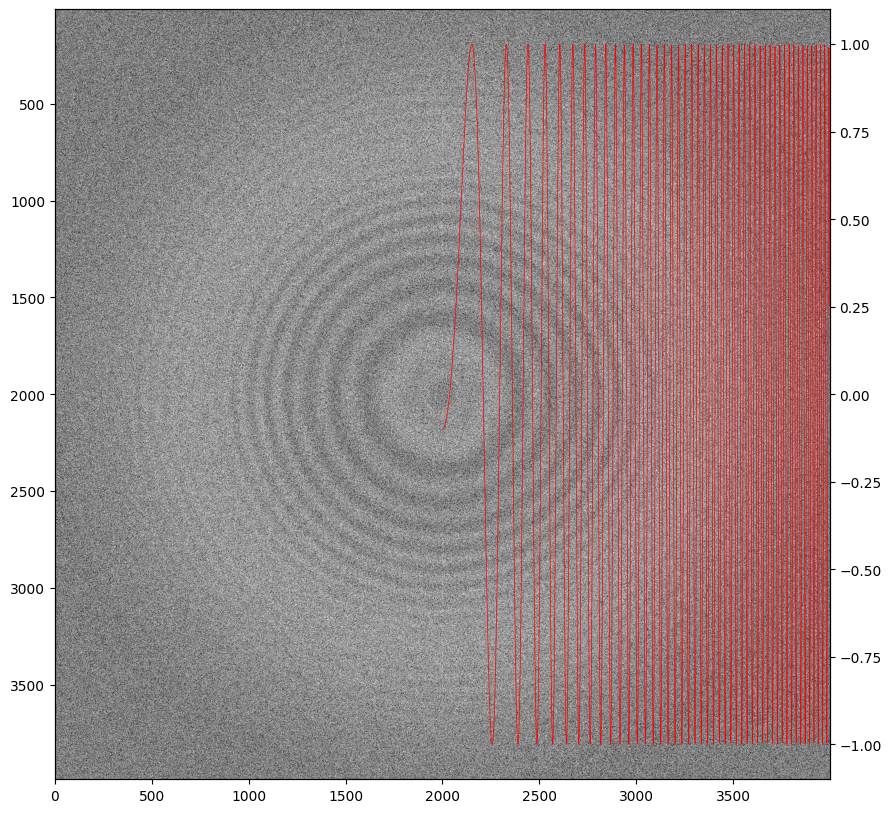

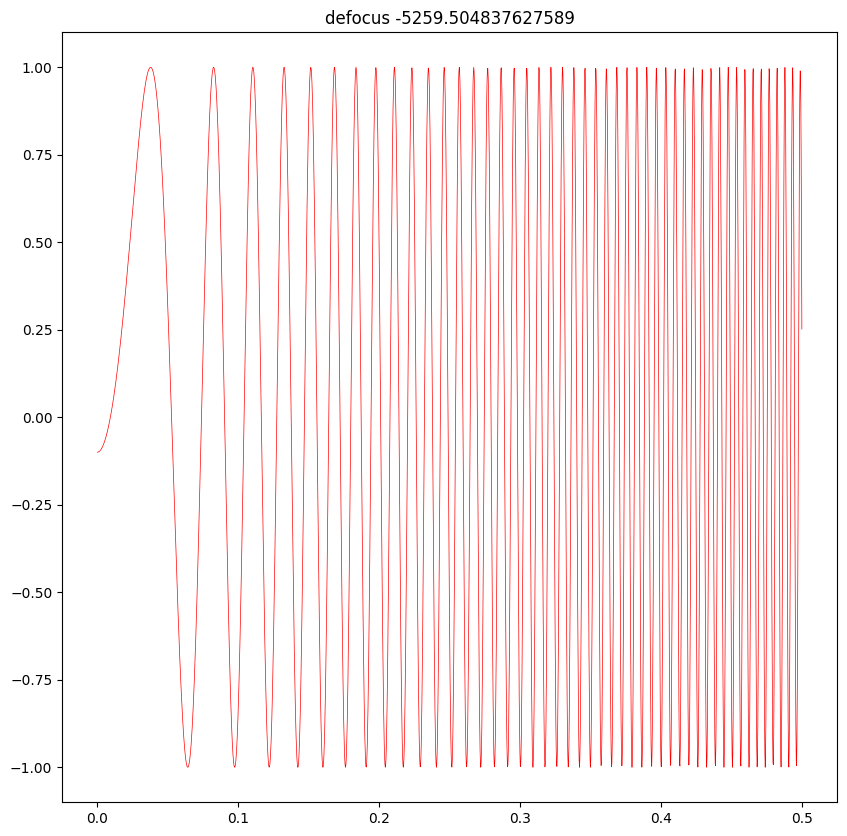

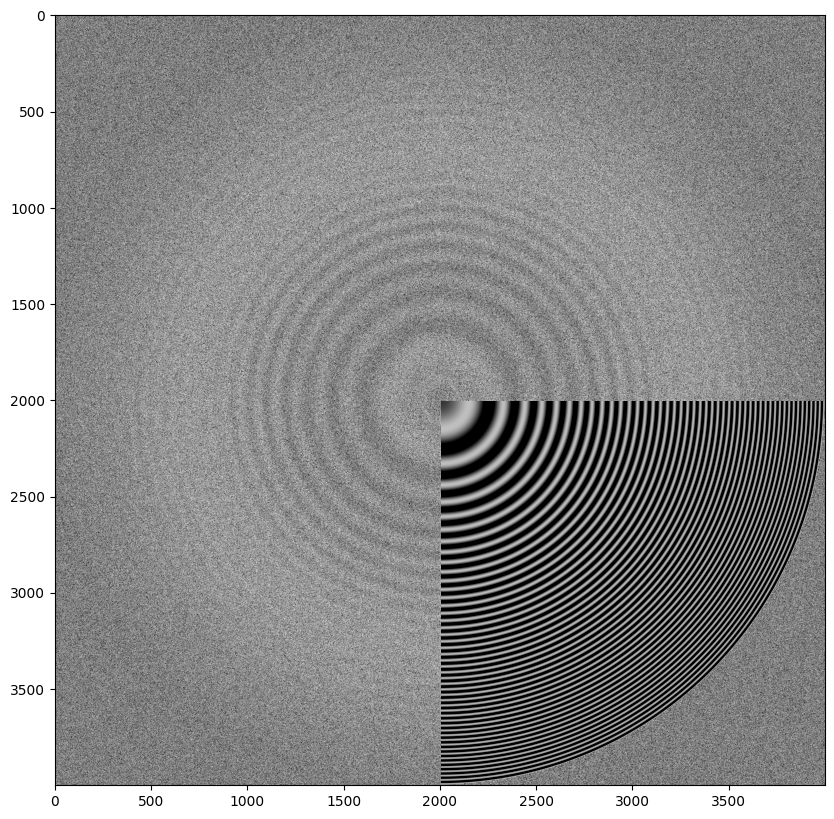

In [26]:
# get the micrograph name
ugraph_index = 100
mrc_dir = config_dir
pixel_size = 1.0 # in Angstroms


ugraph_filename = np.unique(df_picked["ugraph_filename"])[ugraph_index]
print(f"plotted index {ugraph_index}; micrograph: {ugraph_filename}")

ugraph_path = os.path.join(mrc_dir, ugraph_filename)
ugraph = mrcfile.open(ugraph_path).data[0, :, :]

ugraph_ft = np.fft.fftshift(np.fft.fft2(ugraph))
magnitude_spectrum = 20 * np.log(np.abs(ugraph_ft))

# for contrast, only plot the middle 80% of the spectrum
vmin = np.nanpercentile(magnitude_spectrum, 10)
vmax = np.nanpercentile(magnitude_spectrum, 90)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(magnitude_spectrum, cmap="gray", vmin=vmin, vmax=vmax)


###
defocusU = -5259.504837627589
amp = 0.1
Cs = 2.7 # in mm
B = 0.0
voltage = 300 # in kV

def ctf_1d(k, defocus, amp, Cs, B, voltage):
    wavelength = _relativistic_lambda(voltage) / 10 # in nm
    gamma = (-np.pi / 2) * Cs * np.power(wavelength, 3) * np.power(
        k, 4
    ) + (np.pi * wavelength * defocus * np.power(k, 2))
    CTF = (-1 * np.sin(amp + gamma)) * np.exp(-B * np.power(k, 2))
    return CTF

max_freq = 1/ (2 * pixel_size)
num_points = ugraph.shape[0] // 2

freqs = np.linspace(
    0, max_freq, num_points, endpoint=False
)
ctf = ctf_1d(freqs, defocusU, amp, Cs, B, voltage)
ctf_interpolate = interpolate.interp1d(
        freqs, ctf, fill_value="extrapolate"
    )

freq_x, freq_y = np.meshgrid(freqs, freqs)
freq_2d = np.sqrt(np.power(freq_x, 2) + np.power(freq_y, 2))
ctf_2d = ctf_interpolate(freq_2d)

# set ctf_2d to nan outside of circle
ctf_2d[freq_2d > max_freq] = np.nan
# embed ctf_2d into an array of the same size as the micrograph
before_x = (ugraph.shape[0] - ctf_2d.shape[0]) # aligns ctf_2d with the right side of the micrograph
after_x = 0
before_y = (ugraph.shape[1] - ctf_2d.shape[1]) # aligns ctf_2d with the bottom of the micrograph
after_y = 0
ctf_2d = np.pad(ctf_2d, ((before_x, after_x), (before_y, after_y)), mode="constant", constant_values=np.nan)

vmin_ctf = np.nanpercentile(ctf_2d, 5) * 0.5
vmax_ctf = np.nanpercentile(ctf_2d, 99.99) * 1.5

ax2 = ax.twinx()
x = range(ugraph.shape[0]//2, ugraph.shape[0])
ax2.plot(x, ctf, color="r", linewidth=0.5, alpha=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(freqs, ctf, color="r", linewidth=0.5, alpha=1)
ax.set_title(f"defocus {defocusU}")

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(magnitude_spectrum, cmap="gray", vmin=vmin, vmax=vmax)
ax.imshow(ctf_2d, cmap="gray", vmin=vmin_ctf, vmax=vmax_ctf)




In [ ]:
### plot the CTF estimation for a single micrograph
meta_index = 0 # index of the metadata file to plot
ugraph_index = 3 # which micrograph to plot

fig, ax = plot_CTF(df_picked, meta_files[meta_index],
                    df_truth, config_dir, ugraph_index)

# save high quality figure
# fig.savefig("CTF.png", dpi=600, bbox_inches="tight")
# fig.savefig("CTF.eps", bbox_inches="tight")


In [ ]:
### plot the CTF for the particle with the largest defocus error (should take no more than a few seconds)
max_error_index = 0
max_error = 0
for i, groupname in enumerate(df_picked.groupby(["ugraph_filename"]).groups.keys()):
    defocus_estimated = df_picked.groupby(["ugraph_filename"]).get_group(groupname)["defocusU"].mean()
    defcous_true = np.abs(df_truth.groupby(["ugraph_filename"]).get_group(groupname)["defocus"].mean())
    error = np.abs(defocus_estimated - defcous_true)
    if error > max_error:
        max_error = error
        max_error_index = i

fig, ax = plot_CTF(df_picked, None, df_truth, config_dir, max_error_index)

# save high quality figure
fig.savefig("CTF_max_error.png", dpi=600, bbox_inches="tight")
fig.savefig("CTF_max_error.eps", bbox_inches="tight")



### Particle picking

In [ ]:
### plot the picked particles
ugraph_index = 0 # which micrograph to plot
metadata_index = 0 # which metadata file to plot


fig, ax = label_micrograph_picked(df_picked, meta_files[meta_index],
                                   ugraph_index, config_dir, box_width=48, box_height=48, verbose=verbose)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
fig.set_size_inches(7, 7)

# save high quality figure
fig.savefig("picked_particles.png", dpi=600, bbox_inches="tight")
fig.savefig("picked_particles.eps", bbox_inches="tight")
# remove legend
ax.get_legend().remove()

In [ ]:
### plot the truth particles
ugraph_index = 3 # which micrograph to plot

fig, ax = label_micrograph_truth(df_truth, ugraph_index, config_dir, box_width=32, box_height=32, verbose=verbose)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
fig.set_size_inches(7, 7)


In [ ]:
### plot the truth and picked particles
ugraph_index = 3 # which micrograph to plot
metadata_index = 3 # which metadata file to plot

fig, ax = label_micrograph_truth_and_picked(df_picked, meta_files[meta_index],
                                             df_truth, ugraph_index, config_dir, box_width=48, box_height=48, verbose=verbose)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
fig.set_size_inches(7, 7)


In [ ]:
### compute precision and recall (may take a few minutes)
df_precision, df_picked = analysis.compute_precision(df_picked, df_truth, verbose=verbose)
df_precision.tail()


In [ ]:
### plot boxplot for precision and recall
jobtypes = {
    "data/20230531_Sobhan_simulated/cryoSPARC/picked_particles.cs": "blob picker",
    "data/20230531_Sobhan_simulated/cryoSPARC/J584_050_particles.cs": "2D classification",
    "data/20230531_Sobhan_simulated/cryoSPARC/particles_selected.cs": "2D class selection",
    "data/20230531_Sobhan_simulated/cryoSPARC/J586_class_00_final_particles.cs": "3D class 0",
    "data/20230531_Sobhan_simulated/cryoSPARC/J586_class_01_final_particles.cs": "3D class 1",
    "data/20230531_Sobhan_simulated/cryoSPARC/J586_class_02_final_particles.cs": "3D class 2",
    "data/20230531_Sobhan_simulated/cryoSPARC/J586_class_03_final_particles.cs": "3D class 3",
}

order = []
for r in meta_files:
    if type(r) == str:
        order.append(r)
    else:
        order.append(r[0])    
fig, ax = plot_precision(df_precision, jobtypes, order)
fig.set_size_inches([15,10])

fig.savefig("precision.png", dpi=600, bbox_inches="tight")
fig.savefig("precision.pdf", bbox_inches="tight")

fig, ax = plot_recall(df_precision, jobtypes, order)
fig.set_size_inches([15,10])

fig.savefig("recall.png", dpi=600, bbox_inches="tight")
fig.savefig("recall.pdf", bbox_inches="tight")


In [ ]:
### alternatively, plot the precision and recall in the same plot
fig, ax = plot_precision_and_recall(df_precision, jobtypes)


In [ ]:
### plot f1-score
fig, ax = plot_f1_score(df_precision, jobtypes)
fig.set_size_inches(10,10)


In [ ]:
### plot the picked particles, now with the TP and FP marked in green and red
ugraph_index = 3 # which micrograph to plot
metadata_index = 4 # which metadata file to plot

fig, ax = label_micrograph_picked(df_picked, meta_files[meta_index], ugraph_index, config_dir, box_width=48, box_height=48, verbose=verbose)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
fig.set_size_inches(7, 7)

In [ ]:
### plot the distribution of the particles in the ugraphs in x, y, and z directions
metadata_index = 0 # which metadata file to plot
bin_width = [100, 100, 10] # bin width for x, y, z
axis = ["x", "y", "z"]

metadata_filename = meta_files[metadata_index]
for a, bnwdth in zip(axis, bin_width):
    fig, ax = plot_boundary_investigation(df_truth, df_picked, metadata_filename, bnwdth, axis=a)

In [ ]:
df_overlap = analysis.compute_overlap(df_picked, df_truth, verbose=verbose)
df_overlap.head()

In [ ]:
### plot the overlap between the picked and truth particles
metadata_index = 0 # which metadata file to plot. If None, all metadata files are plotted

metadata_filename = meta_files[metadata_index]
fig, ax = plot_overlap_investigation(df_overlap, None, jobtypes=jobtypes)
ax.legend().set_visible(False)
ax.set_xlim((0, 50))
fig.tight_layout()


In [ ]:
### plot the distribution of trajectory frames in a metadata file
metadata_index = 6 # which metadata file to plot

metadata_filename = meta_files[metadata_index]
if isinstance(metadata_filename, list):
    metadata_filename = metadata_filename[0]
print(metadata_filename)

fig, ax = plot_frame_distribution(df_picked, metadata_filename, df_truth, particle_diameter, jobtypes)
fig.set_size_inches(10,10)
fig.savefig("frame_distribution.png", dpi=600, bbox_inches="tight")
fig.savefig("frame_distribution.pdf", bbox_inches="tight")


### 2D classification

In [ ]:
### plot the precision per class
metadata_index = 5 # which metadata file to plot. Must have a class2D column

metadata_filename = meta_files[metadata_index]
if isinstance(metadata_filename, list):
    metadata_filename = metadata_filename[0]

fig, ax = plot_2Dclass_precision(df_picked, metadata_filename, jobtypes)


In [ ]:
### plot the distribution of frames over the 2D classes
metadata_index = 12 # which metadata file to plot. Must have a class2D column

metadata_filename = meta_files[metadata_index]
if isinstance(metadata_filename, list):
    metadata_filename = metadata_filename[0]

fig, ax = plot_2Dclasses_frames(df_picked, metadata_filename, binfactor=100)

fig.savefig("2Dclass_frames.png", dpi=600, bbox_inches="tight")	
fig.savefig("2Dclass_frames.pdf", bbox_inches="tight")

### 3D alignment

In [ ]:
### plot the distribution of particle poses in the picked and truth particles
meta_index = 6

metadata_filename = meta_files[meta_index]
if isinstance(metadata_filename, list):
    metadata_filename = metadata_filename[0]
print(metadata_filename)

grid, vmin, vmax = plot_picked_pose_distribution(df_picked, metadata_filename)
grid.fig.set_size_inches(14, 7)
grid.fig.tight_layout()
grid.fig.savefig("picked_pose_distribution.png", dpi=600, bbox_inches="tight")
grid.fig.savefig("picked_pose_distribution.pdf", bbox_inches="tight")

# grid = plot_true_pose_distribution(df_truth, vmin, vmax)
# grid.fig.set_size_inches(14, 7)
# grid.fig.tight_layout()
# grid.fig.savefig("true_pose_distribution.png", dpi=600, bbox_inches="tight")
# grid.fig.savefig("true_pose_distribution.pdf", bbox_inches="tight")


# Miscelaneous things

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from emmer.pdb.convert.convert_pdb_to_map import convert_pdb_to_map
from emmer.ndimage.filter.low_pass_filter import low_pass_filter
from emmer.ndimage.compute_real_space_correlation import compute_real_space_correlation
import os
import gemmi
from tqdm import tqdm 


In [ ]:
df_grouped = df_picked.groupby("metadata_filename").get_group(meta_files[-1])
print(len(df_grouped))
df_grouped.head()

In [ ]:
# adding columns for latent space coordinates from a heterogenous reconstruction
latent_file = "data/6xm5_steered_Roodmus_2/cryoSPARC/J526_latents_019446.cs"
# latent_file = "data/c3c3b/cryoSPARC/J567_latents_013024.cs"
# latent_file = "data/c3c3b/cryoSPARC/J574_latents_013024.cs"
latents = np.load(latent_file)
print(latents.dtype.names)
print(f"number of latents: {len(latents)}")

for name in latents.dtype.names:
    df_grouped[name] = latents[name]

# adding the angle
angle = pd.read_csv("data/6xm5_steered_Roodmus_1/trj/angles.csv")

for i, row in df_picked.iterrows():
    pdb_index = row["closest_pdb_index"]
    if pdb_index >= 0:
        df_picked.at[i, "angle"] = angle.iloc[int(pdb_index)]["angle"]

df_grouped.head()

In [ ]:
dt = 5*2 / 1000 # ps per frame
angle["time"] = angle["frame_id"] * dt

# plot the angles
fig, ax = plt.subplots(figsize=(7, 3.5))
plt.rcParams.update({'font.size': 12})
sns.lineplot(data=angle,
             x="time",
             y="angle",
             ax=ax,
             color="black",
             alpha=0.5)
# plot markers over the line every 100 frames
sns.scatterplot(data=angle[::100],
                x="time",
                y="angle",
                hue="angle",
                ax=ax,
                palette="RdYlBu_r",
                legend=False,
                s=30,
                alpha=1)
ax.set_xlabel("time [ps]")
ax.set_ylabel("angle")
fig.tight_layout()

fig.savefig("angle.eps", bbox_inches="tight")
fig.savefig("angle.png", dpi=600, bbox_inches="tight")

In [ ]:
# plot the latent space
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.histplot(data=df_grouped, x="components_mode_0/value", ax=ax, bins=100)
ax.set_xlabel("latent z")

# grid = sns.jointplot(
#     data=df_grouped,
#     x="components_mode_0/value",
#     y="components_mode_1/value",
#     kind="hex",
#     xlim=(-1.5, 1.5),
#     ylim=(-1.5, 1.5),
#     height=10,
#     marginal_kws=dict(bins=100, fill=False),
#     color="k",
#     palette="RdBu",
#     bins="log",
# )
# grid.set_axis_labels("latent z", "latent y", fontsize=20)


# grid.fig.savefig("latent_space.png", dpi=600, bbox_inches="tight")
# grid.fig.savefig("latent_space.pdf", bbox_inches="tight")

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(15, 10))
# # sns.scatterplot(data=df_picked, x="components_mode_0/value", y="angle", ax=ax)
# sns.kdeplot(data=df_picked, x="components_mode_0/value", y="angle", ax=ax, levels=10, color="black")

# fig.savefig("latent_space_angle_kde.png", dpi=600, bbox_inches="tight")
# fig.savefig("latent_space_angle_kde.pdf", bbox_inches="tight")

grid = sns.jointplot(data=df_picked, x="components_mode_0/value", y="angle", kind="hex", gridsize=65, cmap="RdBu_r", bins="log", marginal_kws=dict(bins=100, fill=False), color="k")
grid.ax_joint.set_xlabel("latent z")

fig.savefig("latent_space_angle_hexbin.png", dpi=600, bbox_inches="tight")
fig.savefig("latent_space_angle_hexbin.pdf", bbox_inches="tight")


In [ ]:
# for each map in the vseries, correlate against the pdb files in the trajectory

# vseries_dir = "data/6xm5_steered_Roodmus_2/cryosparc_P51_J527_series_000/"
# ensemble_filename = "data/6xm5_steered_Roodmus_2/cryosparc_P51_J527_series_000/small_ensemble_fit_to_vseries.pdb"
# mask_filename = "data/6xm5_steered_Roodmus_2/cryosparc_P51_J527_series_000/ensemble_mask.mrc"
# latent_coordinates = np.linspace(-1.0827, 0.5707, 41)

# vseries_dir = "data/c3c3b/cryosparc_P51_J572_series_000/"
# ensemble_filename = "data/c3c3b/trj/c3_to_c3b_morph_attempt_2_ensemble_fit_to_J572_series_0.pdb"
# mask_filename = "data/c3c3b/cryosparc_P51_J572_series_000/J572_series_0_mask.mrc"
# latent_coordinates = np.linspace(-0.93354666, 0.80533326, 41)

vseries_dir = "data/c3c3b/cryosparc_P51_J575_series_000/"
ensemble_filename = "data/c3c3b/trj/c3_to_c3b_morph_attempt_2_ensemble_fit_to_J575_series_0.pdb"
mask_filename = "data/c3c3b/cryosparc_P51_J575_series_000/J575_series_0_mask.mrc"
latent_coordinates = np.linspace(-0.98666668, 1.15733337, 41)


ensemble_gemmi = gemmi.read_structure(ensemble_filename)
mask = np.array(gemmi.read_ccp4_map(mask_filename).grid)
# threshold the mask at 2*sigma
threshold = 2 * np.std(mask)
print(f"threshold: {threshold}")
mask[mask < threshold] = 0
mask[mask >= threshold] = 1

resolution = 4
results = {
    "frame_index": [],
    "model_index": [],
    "latent_coordinate": [],
    "rscc": [],
    "rscc_T": [],
}
progressbar = tqdm(total=len(os.listdir(vseries_dir)))
for filename in os.listdir(vseries_dir):
    if filename.endswith(".mrc") and "mask" not in filename:
        mrc_file = os.path.join(vseries_dir, filename)
        mrc = gemmi.read_ccp4_map(mrc_file)
        vsize = mrc.grid.spacing[0]
        vseries_index = int(filename.split(".")[0].split("_")[-1])

        for model_index, model in enumerate(ensemble_gemmi):
            tmp_structure = gemmi.Structure()
            tmp_structure.add_model(model)
            map_from_model_unfiltered = convert_pdb_to_map(
                input_pdb=tmp_structure,
                unitcell=mrc.grid.unit_cell,
                size=mrc.grid.shape,
                return_grid=False,
            )
            map_from_model_zyx = low_pass_filter(
                map_from_model_unfiltered, resolution, vsize
            )
            map_from_model = np.rot90(
                np.flip(map_from_model_zyx, axis=0), axes=(2, 0)
            )

            # apply mask to both maps
            map_from_model = np.array(map_from_model) * mask
            # map_from_model_zyx *= mask
            targetmap_data = np.array(mrc.grid) * mask


            rscc = compute_real_space_correlation(
                map_from_model,
                targetmap_data,
            )
            rscc_T = compute_real_space_correlation(
                map_from_model_zyx,
                targetmap_data,
            )
                

            frame_index = model_index* 200
            # print(f"{frame_index}: {rscc}")

            results["frame_index"].append(frame_index)
            results["model_index"].append(model_index)
            results["latent_coordinate"].append(latent_coordinates[vseries_index])
            results["rscc"].append(rscc)
            results["rscc_T"].append(rscc_T)
            progressbar.set_postfix(rscc=rscc)

        # break

    progressbar.update(1)
    progressbar.set_description(f"frame {filename}")


progressbar.close()



In [ ]:
# transform the output into a 2D array
rscc = np.zeros((len(latent_coordinates), len(ensemble_gemmi)))
for i, frame_index in enumerate(results["frame_index"]):
    latent_index = np.where(latent_coordinates == results["latent_coordinate"][i])[0][0]
    rscc[latent_index, frame_index//200] = results["rscc"][i]


min_rscc = np.min(rscc)
max_rscc = np.max(rscc)
# plot the results
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(rscc, ax=ax, cmap="RdBu_r", vmin=min_rscc, vmax=max_rscc)
ax.set_xlabel("frame index")
ax.set_ylabel("latent coordinate")

fig.savefig("rscc.png", dpi=600, bbox_inches="tight")
fig.savefig("rscc.pdf", bbox_inches="tight")
# save the results
np.save("rscc.npy", rscc)



In [ ]:
map_from_model_unfiltered = convert_pdb_to_map(
    input_pdb=tmp_structure,
    unitcell=mrc.grid.unit_cell,
    size=mrc.grid.shape,
    return_grid=False,
)
map_from_model_zyx = low_pass_filter(
    map_from_model_unfiltered, resolution, vsize
)
map_from_model = np.rot90(
    np.flip(map_from_model_zyx, axis=0), axes=(2, 0)
)
# map_from_model = map_from_model.T

plot_axis =1

fig, ax = plt.subplots()
ax.imshow(np.mean(map_from_model, axis=plot_axis))
fig, ax = plt.subplots()
ax.imshow(np.mean(np.array(mrc.grid), axis=plot_axis))
fig, ax = plt.subplots()
ax.imshow(np.mean(mask, axis=plot_axis))

fig, ax = plt.subplots()
ax.imshow(np.mean(map_from_model*mask, axis=plot_axis))
fig, ax = plt.subplots()
ax.imshow(np.mean(np.array(mrc.grid)*mask, axis=plot_axis))

rscc = compute_real_space_correlation(
    map_from_model*mask,
    np.array(mrc.grid)*mask,
)

print(mrc_file)
print(model_index)
print(rscc)


In [ ]:
df = pd.DataFrame(results)
df